In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse,aic

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
r=pd.read_csv("/content/drive/My Drive/stock/final_UPL.NS.csv")
nt=pd.read_csv("/content/drive/My Drive/tone/pct730/pct730_phosphorus limited.csv")
df=pd.DataFrame()
df['return']=r['return']
df['negative tone']=nt['PCT']
df['Date']=r['Date']
df.set_index('Date',inplace=True)
df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df.replace([np.inf, -np.inf], np.nan)

df.dropna(inplace=True)
df



,return,negative tone
Date,,
2018-01-01,0.00,0.00
2018-01-02,2.34,0.00
2018-01-03,0.30,0.78
2018-01-04,0.75,1.20
2018-01-05,-0.95,0.00
...,...,...
2019-12-27,0.07,0.00
2019-12-28,0.00,0.00
2019-12-29,0.00,0.00


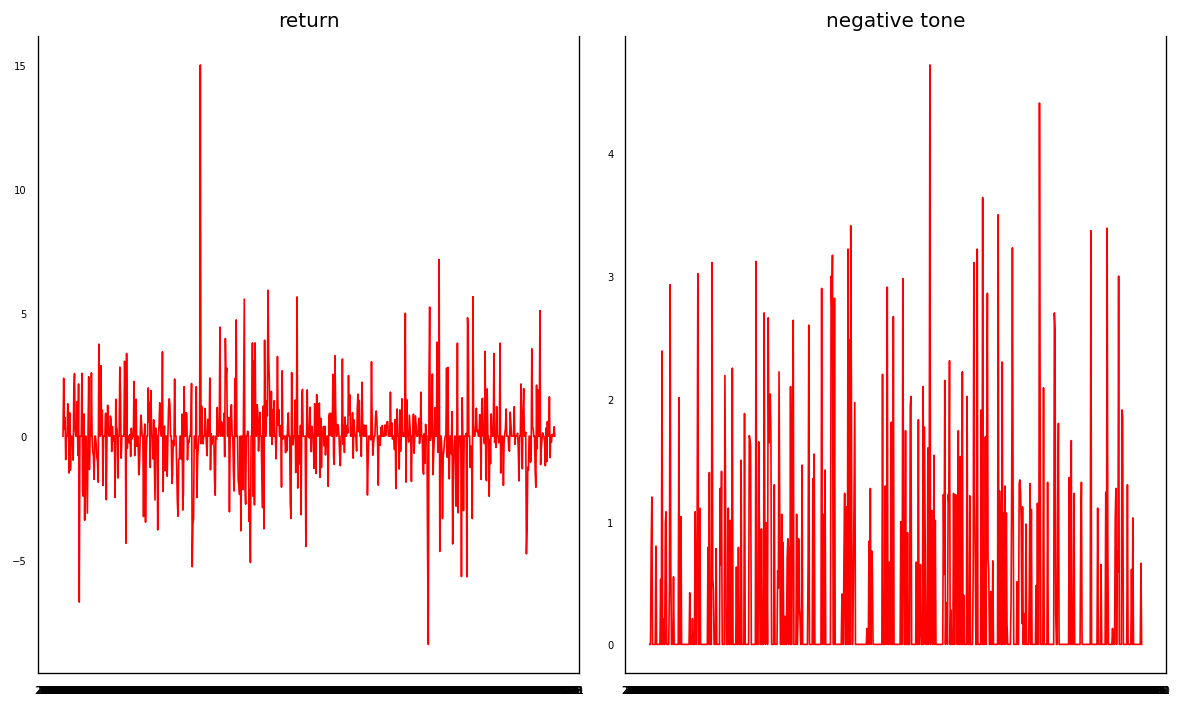

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,return_x,negative tone_x
return_y,1.000,0.2209
negative tone_y,0.161,1.0000


In [ ]:
# Results from Granger Casuality test can be read as : negative tone causes return (10% significance) but return do not causes negative tone.


In [ ]:
t = 5
df_train, df_test = df[0:-t], df[-t:]

# Check size
print(df_train.shape)  # (655, 2)
print(df_test.shape)  # (73, 2)


(723, 2)
(5, 2)


In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [ ]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.992
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "negative tone" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.1001
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [ ]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
print(df_train[-t:])   

Lag Order = 1
AIC :  0.6349346415696356
BIC :  0.6730124128069722
FPE :  1.8868989931700562
HQIC:  0.6496328543649829 

Lag Order = 2
AIC :  0.6456911477542705
BIC :  0.7092228972311769
FPE :  1.9073056514185807
HQIC:  0.6702163037583224 

Lag Order = 3
AIC :  0.6586645197468499
BIC :  0.7477055155359352
FPE :  1.932212549670356
HQIC:  0.6930392230194309 

Lag Order = 4
AIC :  0.667877408660271
BIC :  0.7824831171984892
FPE :  1.9500987726886783
HQIC:  0.7121243462844701 

Lag Order = 5
AIC :  0.6758145306036485
BIC :  0.8160406176775495
FPE :  1.9656428182233174
HQIC:  0.7299564731027567 

Lag Order = 6
AIC :  0.6822234567568559
BIC :  0.8481257884940807
FPE :  1.9782871715995407
HQIC:  0.7462832585139572 

Lag Order = 7
AIC :  0.6878715202055478
BIC :  0.879506164072614
FPE :  1.9895008596024837
HQIC:  0.7618721198857848 

Lag Order = 8
AIC :  0.6959978943134644
BIC :  0.9134211201198927
FPE :  2.0057455190688835
HQIC:  0.7799623152889998 

Lag Order = 9
AIC :  0.7006357560298792
BIC

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,0.6518*,0.6647*,1.919*,0.6568*
1,0.6544,0.6930,1.924,0.6693
2,0.6653,0.7295,1.945,0.6901
3,0.6759,0.7658,1.966,0.7106
4,0.6839,0.7995,1.982,0.7286
5,0.6898,0.8311,1.993,0.7444
6,0.6939,0.8609,2.001,0.7584
7,0.6972,0.8899,2.008,0.7717
8,0.7035,0.9219,2.021,0.7879
9,0.7056,0.9497,2.025,0.7999


In [ ]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 02, Jan, 2021
Time:                     19:02:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.673012
Nobs:                     722.000    HQIC:                  0.649633
Log likelihood:          -2272.16    FPE:                    1.88690
AIC:                     0.634935    Det(Omega_mle):         1.87132
--------------------------------------------------------------------
Results for equation return
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.074036         0.071127            1.041           0.298
L1.return               -0.042915         0.037226           -1.153           0.249
L1.negative tone        -0.094571         0.077

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

return : 2.0
negative tone : 2.0


In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #1

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

1


array([[-0.23,  0.  ]])

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=t)

df_forecast = pd.DataFrame(fc, index=df.index[-t:], columns=df.columns)
df_forecast

,return,negative tone
Date,,
2019-12-27,0.083907,0.392227
2019-12-28,0.033342,0.422785
2019-12-29,0.032622,0.424148
2019-12-30,0.032524,0.424229
2019-12-31,0.032521,0.424234


In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr})

print('Forecast Accuracy of: return')
accuracy_prod = forecast_accuracy(df_forecast['return'].values, df_test['return'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: negative tone')
accuracy_prod = forecast_accuracy(df_forecast['negative tone'].values, df_test['negative tone'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))



Forecast Accuracy of: return
mape :  inf
me :  -0.047
mae :  0.092
mpe :  inf
rmse :  0.1576
corr :  -0.0735

Forecast Accuracy of: negative tone
mape :  inf
me :  0.2855
mae :  0.3798
mpe :  inf
rmse :  0.3868
corr :  0.2648
